# Face-Dell, AI face generation model

## Imports

In [2]:
import os
import csv
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import DiffusionPipeline,StableDiffusionPipeline, EulerDiscreteScheduler, UNet2DConditionModel, PNDMScheduler
from accelerate import Accelerator
from dataclasses import dataclass
from datasets import load_dataset

c:\Users\precision\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


## Capturing photos

In [1]:
from webcam_capture import capture_photos

capture_photos(output_dir='data/user/', num_photos=4)

delay: 13.368216276168823 seconds
Photo saved: data/user/user_0000.jpg
Photo saved: data/user/user_0001.jpg
Photo saved: data/user/user_0002.jpg
Photo saved: data/user/user_0003.jpg


## Variables definition

In [2]:
manual_seed = 42

In [3]:
# Definitions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = torch.Generator(device).manual_seed(manual_seed)
model_id = "runwayml/stable-diffusion-v1-5"
scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")

pipe = StableDiffusionPipeline.from_pretrained(
    model_id, 
    scheduler=scheduler,
    unet=unet,
    tokenizer=tokenizer,
    text_encoder=text_encoder,
    torch_dtype=torch.float,
    use_safetensors=True,
)

pipe.to(device)

c:\Users\precision\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 12.55it/s]


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.28.0.dev0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## Fine-tuning

In [4]:
@dataclass
class TrainingConfig:
    image_size = 512  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_model_id = "kurouge/facedell"  # the name of the repository to create on the HF Hub
    hub_private_repo = True
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [5]:
# Load the dataset
# config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset("imagefolder", split="train", data_dir="data/user")

In [6]:

# Transform 
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

In [11]:
dataset[0]

{'images': tensor([[[ 0.2078,  0.2000,  0.2000,  ...,  0.0118,  0.0118,  0.0118],
          [ 0.2078,  0.1922,  0.1765,  ...,  0.0118,  0.0118,  0.0118],
          [ 0.2000,  0.1843,  0.1608,  ...,  0.0118,  0.0118,  0.0118],
          ...,
          [ 0.3882,  0.4745,  0.4902,  ..., -0.8275, -0.8353, -0.8431],
          [ 0.4118,  0.4980,  0.4980,  ..., -0.8275, -0.8275, -0.8353],
          [ 0.4196,  0.4980,  0.4902,  ..., -0.8196, -0.8275, -0.8353]],
 
         [[ 0.2000,  0.1922,  0.1922,  ...,  0.0275,  0.0275,  0.0275],
          [ 0.2000,  0.1922,  0.1765,  ...,  0.0275,  0.0275,  0.0275],
          [ 0.1922,  0.1843,  0.1529,  ...,  0.0275,  0.0275,  0.0275],
          ...,
          [ 0.5294,  0.4588,  0.2314,  ..., -0.7725, -0.7804, -0.7804],
          [ 0.5216,  0.3961,  0.1216,  ..., -0.7725, -0.7725, -0.7804],
          [ 0.5059,  0.3569,  0.0667,  ..., -0.7647, -0.7725, -0.7804]],
 
         [[ 0.2235,  0.2157,  0.2157,  ...,  0.0431,  0.0431,  0.0353],
          [ 0.2235

In [ ]:
# Training script

accelerator = Accelerator()

optimizer = torch.optim.Adam(unet.parameters(), lr=config.learning_rate)
training_dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)
model = unet


model, optimizer, training_dataloader, scheduler = accelerator.prepare(
     model, optimizer, training_dataloader, scheduler
  )

loss_function = torch.nn.CrossEntropyLoss()

for batch in training_dataloader:
    optimizer.zero_grad()
    inputs, targets = batch
    inputs = inputs.to(device)
    targets = targets.to(device)
    outputs = model(inputs)
    loss = loss_function(outputs, targets)
    accelerator.backward(loss)
    optimizer.step()
    scheduler.step()

In [ ]:
for batch in training_dataloader:
    print(batch)

**Equivalent direct pour le terminal**

```
export MODEL_NAME="runwayml/stable-diffusion-v1-5"
export INSTANCE_DIR="./data/idriss2"
export OUTPUT_DIR="models/facedell-model-idriss3"
accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks man" \
  --gradient_checkpointing \
  --use_8bit_adam \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=100 \
  --validation_prompt="a photo of sks man" \
  --num_validation_images=4 \
  --validation_steps=100 \
  # --train_text_encoder \
  ```

## Dreambooth


In [3]:
# Training script using accelerate and example script

os.system('export MODEL_NAME="runwayml/stable-diffusion-v1-5')
os.system('export INSTANCE_DIR="./data"')
os.system('export OUTPUT_DIR="models/facedell-model-amir"')
os.system('accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks man" \
  --gradient_checkpointing \
  --use_8bit_adam \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=500 \
  # --validation_prompt="a photo of sks man" \
  # --num_validation_images=4 \
  # --validation_steps=100 \
  # --train_text_encoder \
  ')

KeyboardInterrupt: 

## Image generation

In [8]:
def save_image_with_metadata(image, metadata, directory='images'):
    """
    Save an image in a directory with an auto-incrementing filename and save metadata to a CSV file.

    :param image: Image to save.
    :param metadata: Dictionary containing metadata about the image.
    :param directory: Directory to save the image and metadata.
    """
    # Ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Create a CSV file for metadata if it doesn't exist
    csv_filepath = os.path.join(directory, 'metadata.csv')
    file_exists = os.path.isfile(csv_filepath)

    # Check if the metadata already exists
    metadata_exists = False
    # Convert all metadata values to strings for comparison
    str_metadata = {k: str(v) for k, v in metadata.items()}
    if file_exists:
        with open(csv_filepath, mode='r', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                if row == str_metadata:
                    metadata_exists = True
                    break

    # Add metadata if it doesn't exist
    if not metadata_exists:
        # Create a filename with an incrementing number
        existing_files = sorted([f for f in os.listdir(directory) if f.startswith('image_') and f.endswith('.png')])
        if existing_files:
            last_file = existing_files[-1]
            last_number = int(last_file.split('_')[1].split('.')[0])
            new_number = last_number + 1
        else:
            new_number = 1
        new_filename = f'image_{new_number:04d}.png'
        new_filepath = os.path.join(directory, new_filename)
        # Save the image
        image.save(new_filepath)
        # Save the metadata
        with open(csv_filepath, mode='a', newline='') as csvfile:
            fieldnames = metadata.keys()
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            if not file_exists:
                writer.writeheader()
            writer.writerow(metadata)
        print(f"Image saved as {new_filepath} with metadata.")
    else:
        print("Image already saved with metadata.")

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\precision\AppData\Local\Programs\Python\Python310\lib\site-packages\diffusers\models\attention_processor.py:1406: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(
100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


Image already saved with metadata.


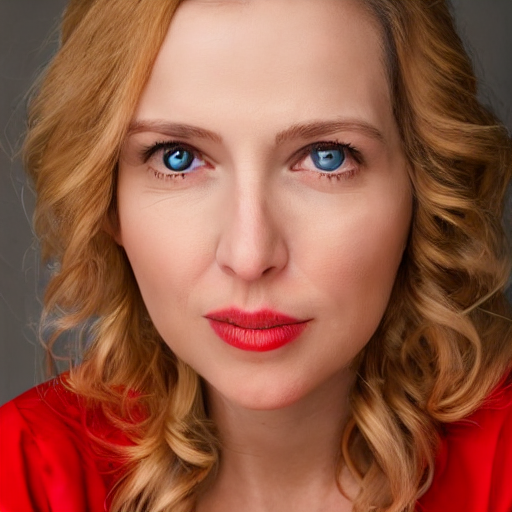

In [9]:
params = {
    "prompt": "A real photorealistic portrait of a face of a beautiful young blond woman in her thirties wearing a red dress.",
    "negative_prompt": "",
    "height":  512,
    "width": 512,
    "num_inference_steps": 100,
    "guidance_scale": 7.5,
    "generator": generator,
} 
output_directory = f"outputs/{model_id}/"
images = pipe(**params).images
image = images[0]
metadata = params.copy()
metadata.update({"generator_seed": metadata.pop("generator").initial_seed()})
save_image_with_metadata(image, metadata, directory=output_directory)
image

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 14.08it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


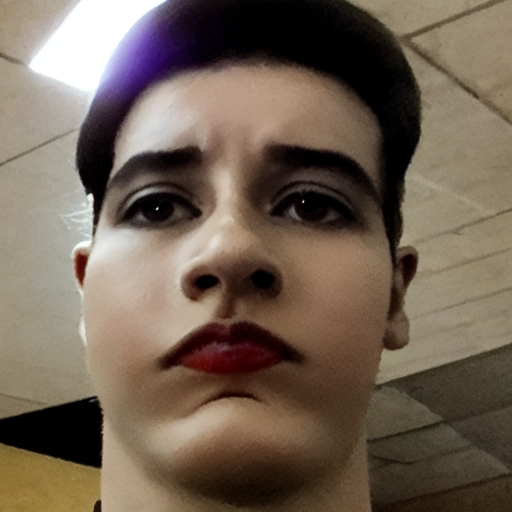

In [52]:
ft_model_id = "models/facedell-model-idriss3"
model_id = "runwayml/stable-diffusion-v1-5"
unet = UNet2DConditionModel.from_pretrained(f"{ft_model_id}/unet", subfolder="unet")
pipeline = StableDiffusionPipeline.from_pretrained(model_id, unet=unet, torch_dtype=torch.float, safety_checker=None, use_safetensors=True).to("cuda")

images = pipeline(prompt="A photo of sks man with big glowing eyes", num_inference_steps=100, guidance_scale=10).images[0]
images

In [49]:
images.save("drikotribal.jpg")